In [1]:
#IMPORTS
import numpy as np
import cv2
import sklearn
import scipy
import imageio
import math
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [2]:
def get_phase_correlations(images):
    offsets = []
    for i in range(len(images)-1):
        d = cv2.phaseCorrelate(images[i], images[i+1])
        offsets.append(d)
    return offsets

In [3]:
def combine_images(image1, image2, offset_x, offset_y):
    offset_x = -int(offset_x)
    offset_y = int(offset_y)
    if offset_x < 0:
        merge_width = max(image2.shape[1], image1.shape[1]-offset_x)
        warp_offset_x = 0
        ref_offset_x = offset_x
    else:
        merge_width = max(image2.shape[1] + offset_x, image1.shape[1])
        warp_offset_x = offset_x
        ref_offset_x = 0
    if offset_y < 0:
        merge_height = max(image2.shape[0], image1.shape[0]-offset_y)
        warp_offset_y = 0
        ref_offset_y = offset_y
    else:
        merge_height = max(image2.shape[0] + offset_y, image1.shape[0])
        warp_offset_y = offset_y
        ref_offset_y = 0
    
    combined_image = np.zeros((merge_height,merge_width,3)).astype(np.uint8)
    for y in range(image2.shape[0]):
        for x in range(image2.shape[1]):
            combined_image[y+warp_offset_y,x+warp_offset_x] = image2[y,x]
    
    for y in range(image1.shape[0]):
        for x in range(image1.shape[1]):
            if np.all((combined_image[y-ref_offset_y,x-ref_offset_x] == 0)):
                combined_image[y-ref_offset_y, x-ref_offset_x] = image1[y,x]
    return combined_image
    
    

In [4]:
images = [imageio.imread("test_images/"+str(x+1)+".jpg") for x in range(12)]
grayscale_images = []
for i in range(len(images)):
    grayscale_images.append(rgb2gray(images[i]))
offsets = get_phase_correlations(grayscale_images)


In [5]:
combined_image = images[0]
offset_x = 0
offset_y = 0
for i in range(len(images)-1):
    offset_x += offsets[i][0][0]
    offset_y += offsets[i][0][1] 
    combined_image = combine_images(combined_image, images[i+1], offset_x, offset_y)

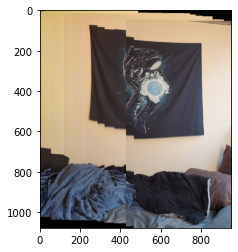

In [6]:
fig,axes = plt.subplots(1,1)
axes.imshow(combined_image)
plt.show()

In [22]:
# Run least squares to solve for focal length
# the equation is 2pi - sum(d_i / f) = 0
# coords = [x[0] for x in offsets]
# coords = np.array(coords)
# x_coords = coords[:, 0]

def cost(f):
    target = 2*np.pi
    value = np.arctan2(x_coords, f).sum()
    return np.abs(target - value)

def compute_focal_length(x_coords):
    return least_squares(cost, 1, bounds=(.001, np.inf))[0]

 active_mask: array([0])
        cost: 19.742918621506345
         fun: array([6.28377572])
        grad: array([-4.71711443e-09])
         jac: array([[-7.5068154e-10]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 34
        njev: 34
  optimality: 4.7171144297516015e-09
      status: 1
     success: True
           x: array([786464.])


In [ ]:
def compute_thetas(widths, focal_length):
    thetas = [0]
    for i in range(1, len(widths)):
        thetas.append(thetas[i-1]+ 2 * np.arctan2(widths[i]/ (focal_length*2) ))
    return thetas
